# **Capstone**: Sprint 1

### *William Reggler – BrainStation Data Science student (September 2024)*

The current goal of this Capstone project is to create a machine learning model that can predict the likelihood of a student in British Columbia (BC) graduating from secondary school. To do this, it is my intention to use publically-available data from both *Statistics Canada* and the *BC Ministry of Education* to train a model on the graduation rates based on location/school district, socioeconomic background, cultural background (including immigrants and indigenous groups), parental education and any other available features.

In [6]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import plotly.express as px

For the first dataset to be explored, I will look at *First-Time Graduation Rate from 1996/7 to 2022/3*, available from the BC Government's data website.

In [159]:
# Import the data
grad_df = pd.read_csv('https://catalogue.data.gov.bc.ca/dataset/58a3f04d-99c5-4696-bff2-602fe69f5363/resource/1873e808-2476-48c8-bd74-c54c24f70fe2/download/first_time_g12_graduation_rate_1996-97-2022-23_residents_only.csv')
grad_df.head()

,SCHOOL_YEAR,DATA_LEVEL,PUBLIC_OR_INDEPENDENT,DISTRICT_NUMBER,DISTRICT_NAME,SCHOOL_NUMBER,SCHOOL_NAME,FACILITY_TYPE,SUB_POPULATION,MEASURE_NAME,FIRST_TIME_GRADE_12_COUNT,FIRST_TIME_GRADUATION_COUNT,GRADUATION_RATE,HONOURS_COUNT,HONOURS_RATE
0,1996/1997,Province Level,Province - Total,NaN,NaN,NaN,NaN,All Facility Types,All Students,First Time Grade 12 Graduation Rate,43075,31556,73,17236,40
1,1996/1997,Province Level,Province - Total,NaN,NaN,NaN,NaN,All Facility Types,Indigenous,First Time Grade 12 Graduation Rate,2114,1028,49,375,18
2,1996/1997,Province Level,Province - Total,NaN,NaN,NaN,NaN,All Facility Types,Non Indigenous,First Time Grade 12 Graduation Rate,40961,30528,75,16861,41
3,1996/1997,Province Level,Province - Total,NaN,NaN,NaN,NaN,All Facility Types,Disabilities or Diverse Abilities,First Time Grade 12 Graduation Rate,413,144,35,59,14
4,1996/1997,Province Level,Province - Total,NaN,NaN,NaN,NaN,All Facility Types,Non Disabilities or Diverse Abilities,First Time Grade 12 Graduation Rate,42662,31412,74,17177,40


In [161]:
grad_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70544 entries, 0 to 70543
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   SCHOOL_YEAR                  70544 non-null  object 
 1   DATA_LEVEL                   70544 non-null  object 
 2   PUBLIC_OR_INDEPENDENT        70544 non-null  object 
 3   DISTRICT_NUMBER              58260 non-null  float64
 4   DISTRICT_NAME                70156 non-null  object 
 5   SCHOOL_NUMBER                62128 non-null  float64
 6   SCHOOL_NAME                  62128 non-null  object 
 7   FACILITY_TYPE                70544 non-null  object 
 8   SUB_POPULATION               70544 non-null  object 
 9   MEASURE_NAME                 70544 non-null  object 
 10  FIRST_TIME_GRADE_12_COUNT    70544 non-null  object 
 11  FIRST_TIME_GRADUATION_COUNT  70544 non-null  object 
 12  GRADUATION_RATE              70389 non-null  object 
 13  HONOURS_COUNT   

This shows a dataset of 70,544 rows with some null values, particularly in the 'District Number', 'School Number' and 'School Name' columns (the reason being that there are students who receive publicly-funded education outside of a traditional school setting.

Next, let's look at the value counts for each column:

In [163]:
for column in grad_df.columns:
    print(f"Value counts for {column}:")
    print(grad_df[column].value_counts().sort_index())
    print("\n")

Value counts for SCHOOL_YEAR:
SCHOOL_YEAR
1996/1997    1873
1997/1998    1982
1998/1999    2114
1999/2000    2247
2000/2001    2280
2001/2002    2334
2002/2003    2364
2003/2004    2376
2004/2005    2424
2005/2006    2514
2006/2007    2506
2007/2008    2552
2008/2009    2580
2009/2010    2700
2010/2011    2722
2011/2012    2743
2012/2013    2775
2013/2014    2884
2014/2015    2873
2015/2016    2918
2016/2017    2954
2017/2018    3014
2018/2019    2965
2019/2020    2976
2020/2021    2971
2021/2022    2952
2022/2023    2951
Name: count, dtype: int64


Value counts for DATA_LEVEL:
DATA_LEVEL
District Level     8028
Province Level      388
School Level      62128
Name: count, dtype: int64


Value counts for PUBLIC_OR_INDEPENDENT:
PUBLIC_OR_INDEPENDENT
BC Independent School    12014
BC Public School         58395
Province - Total           135
Name: count, dtype: int64


Value counts for DISTRICT_NUMBER:
DISTRICT_NUMBER
5.0      884
6.0      956
8.0     1291
10.0     439
19.0     287
20.0  

It already looks like there is a problem: In the columns for graduation rates and honours rates, the highest count of a value is 'Msk' (meaning 'Masked'). In short, the reason for this is one of individual privacy: accurate counts of small groupings makes it possible to identify individual students.

For the full policy, go to https://www2.gov.bc.ca/gov/content/education-training/k-12/administration/legislation-policy/public-schools/protection-of-personal-information-when-reporting-on-small-populations.

When looking at just the graduation rates, a plot looks like this:

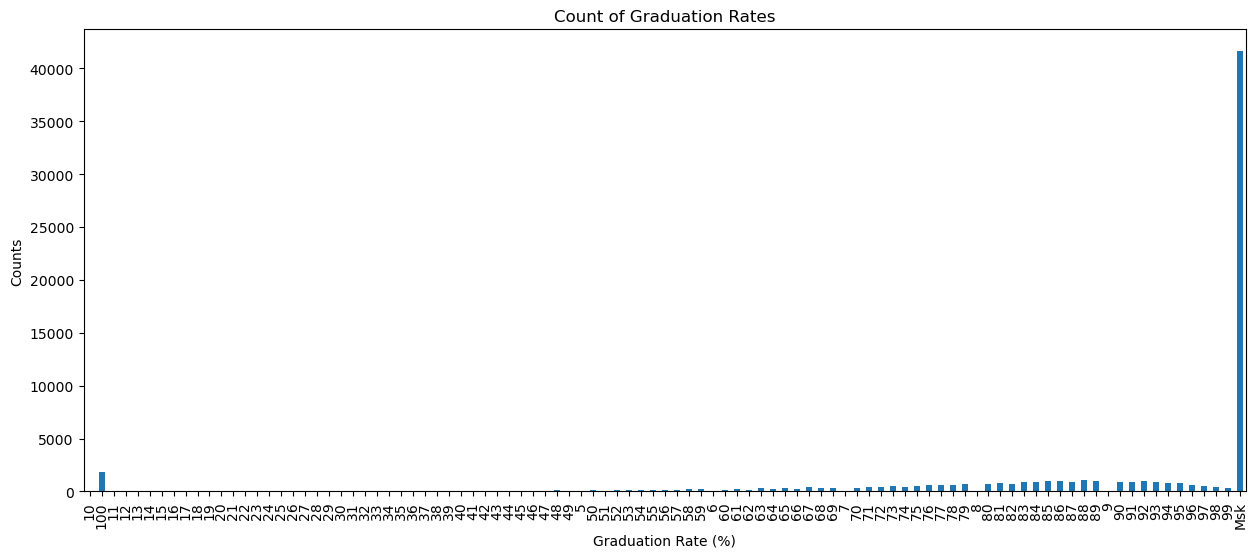

In [165]:
plt.figure(figsize=(15, 6))
grad_df['GRADUATION_RATE'].value_counts().sort_index().plot(kind='bar')
plt.title('Count of Graduation Rates')
plt.xlabel('Graduation Rate (%)')
plt.ylabel('Counts')
plt.show()

That's not useful. For the sake of argument, let's look at what happens when the masked values are made into null values.

In [167]:
# Make a new dataframe
grad_df2 = grad_df

In [169]:
# Convert 'Msk' to NaN
grad_df2 = grad_df2.replace('Msk', np.NaN)

#Show the new dataframe
grad_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70544 entries, 0 to 70543
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   SCHOOL_YEAR                  70544 non-null  object 
 1   DATA_LEVEL                   70544 non-null  object 
 2   PUBLIC_OR_INDEPENDENT        70544 non-null  object 
 3   DISTRICT_NUMBER              58260 non-null  float64
 4   DISTRICT_NAME                70156 non-null  object 
 5   SCHOOL_NUMBER                62128 non-null  float64
 6   SCHOOL_NAME                  62128 non-null  object 
 7   FACILITY_TYPE                70544 non-null  object 
 8   SUB_POPULATION               70544 non-null  object 
 9   MEASURE_NAME                 70544 non-null  object 
 10  FIRST_TIME_GRADE_12_COUNT    37231 non-null  object 
 11  FIRST_TIME_GRADUATION_COUNT  28947 non-null  object 
 12  GRADUATION_RATE              28792 non-null  object 
 13  HONOURS_COUNT   

In [171]:
# Convert graduation (rate) columns to numeric
grad_df2['FIRST_TIME_GRADE_12_COUNT'] = pd.to_numeric(grad_df2['FIRST_TIME_GRADE_12_COUNT'], errors='coerce')
grad_df2['FIRST_TIME_GRADUATION_COUNT'] = pd.to_numeric(grad_df2['FIRST_TIME_GRADUATION_COUNT'], errors='coerce')
grad_df2['GRADUATION_RATE'] = pd.to_numeric(grad_df2['GRADUATION_RATE'], errors='coerce')
grad_df2['HONOURS_COUNT'] = pd.to_numeric(grad_df2['HONOURS_COUNT'], errors='coerce')
grad_df2['HONOURS_RATE'] = pd.to_numeric(grad_df2['HONOURS_RATE'], errors='coerce')
grad_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70544 entries, 0 to 70543
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   SCHOOL_YEAR                  70544 non-null  object 
 1   DATA_LEVEL                   70544 non-null  object 
 2   PUBLIC_OR_INDEPENDENT        70544 non-null  object 
 3   DISTRICT_NUMBER              58260 non-null  float64
 4   DISTRICT_NAME                70156 non-null  object 
 5   SCHOOL_NUMBER                62128 non-null  float64
 6   SCHOOL_NAME                  62128 non-null  object 
 7   FACILITY_TYPE                70544 non-null  object 
 8   SUB_POPULATION               70544 non-null  object 
 9   MEASURE_NAME                 70544 non-null  object 
 10  FIRST_TIME_GRADE_12_COUNT    37231 non-null  float64
 11  FIRST_TIME_GRADUATION_COUNT  28947 non-null  float64
 12  GRADUATION_RATE              28792 non-null  float64
 13  HONOURS_COUNT   

In [173]:
# Filter out rows where the value is below 200 or is NaN (which includes 'Msk')
filtered_grad_df = grad_df2[grad_df2['FIRST_TIME_GRADUATION_COUNT'] >= 10].dropna(subset=['FIRST_TIME_GRADUATION_COUNT'])

# Display the filtered DataFrame
filtered_grad_df.head(100)

,SCHOOL_YEAR,DATA_LEVEL,PUBLIC_OR_INDEPENDENT,DISTRICT_NUMBER,DISTRICT_NAME,SCHOOL_NUMBER,SCHOOL_NAME,FACILITY_TYPE,SUB_POPULATION,MEASURE_NAME,FIRST_TIME_GRADE_12_COUNT,FIRST_TIME_GRADUATION_COUNT,GRADUATION_RATE,HONOURS_COUNT,HONOURS_RATE
0,1996/1997,Province Level,Province - Total,NaN,NaN,NaN,NaN,All Facility Types,All Students,First Time Grade 12 Graduation Rate,43075.0,31556.0,73.0,17236.0,40.0
1,1996/1997,Province Level,Province - Total,NaN,NaN,NaN,NaN,All Facility Types,Indigenous,First Time Grade 12 Graduation Rate,2114.0,1028.0,49.0,375.0,18.0
2,1996/1997,Province Level,Province - Total,NaN,NaN,NaN,NaN,All Facility Types,Non Indigenous,First Time Grade 12 Graduation Rate,40961.0,30528.0,75.0,16861.0,41.0
3,1996/1997,Province Level,Province - Total,NaN,NaN,NaN,NaN,All Facility Types,Disabilities or Diverse Abilities,First Time Grade 12 Graduation Rate,413.0,144.0,35.0,59.0,14.0
4,1996/1997,Province Level,Province - Total,NaN,NaN,NaN,NaN,All Facility Types,Non Disabilities or Diverse Abilities,First Time Grade 12 Graduation Rate,42662.0,31412.0,74.0,17177.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1996/1997,District Level,BC Public School,61.0,Greater Victoria,NaN,NaN,All Facility Types,All Students,First Time Grade 12 Graduation Rate,1621.0,1051.0,65.0,623.0,38.0
188,1996/1997,District Level,BC Public School,61.0,Greater Victoria,NaN,NaN,All Facility Types,Indigenous,First Time Grade 12 Graduation Rate,72.0,26.0,36.0,10.0,14.0
189,1996/1997,District Level,BC Public School,61.0,Greater Victoria,NaN,NaN,All Facility Types,Non Indigenous,First Time Grade 12 Graduation Rate,1549.0,1025.0,66.0,613.0,40.0
192,1996/1997,District Level,BC Public School,62.0,Sooke,NaN,NaN,All Facility Types,All Students,First Time Grade 12 Graduation Rate,582.0,319.0,55.0,168.0,29.0


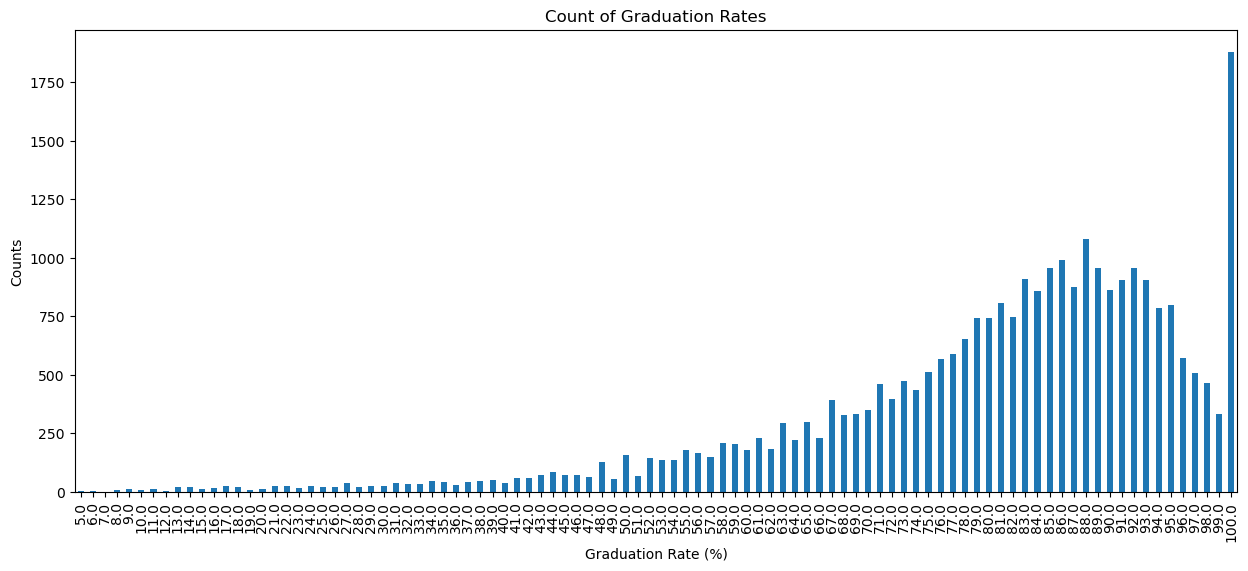

In [175]:
plt.figure(figsize=(15, 6))
filtered_grad_df['GRADUATION_RATE'].value_counts().sort_index().plot(kind='bar')
plt.title('Count of Graduation Rates')
plt.xlabel('Graduation Rate (%)')
plt.ylabel('Counts')
plt.show()

This is more readable, but having removed so much from the original dataframe makes this plot fundamentally flawed.

Let's try from a different angle. It is possible that with so much of BC being made up of small communities, focusing on Metro Vancouver (BC's most urban region) could potentially yield better results. The school districts in Vancouver are SD35 to SD45, so I'll create a new dataframe for just those districts.

In [177]:
vanc_grad_df = grad_df[(grad_df['DISTRICT_NUMBER'] >= 35) & (grad_df['DISTRICT_NUMBER'] <= 45)]
vanc_grad_df.head()

,SCHOOL_YEAR,DATA_LEVEL,PUBLIC_OR_INDEPENDENT,DISTRICT_NUMBER,DISTRICT_NAME,SCHOOL_NUMBER,SCHOOL_NAME,FACILITY_TYPE,SUB_POPULATION,MEASURE_NAME,FIRST_TIME_GRADE_12_COUNT,FIRST_TIME_GRADUATION_COUNT,GRADUATION_RATE,HONOURS_COUNT,HONOURS_RATE
72,1996/1997,District Level,BC Public School,35.0,Langley,NaN,NaN,All Facility Types,All Students,First Time Grade 12 Graduation Rate,1226,899,73,480,39
73,1996/1997,District Level,BC Public School,35.0,Langley,NaN,NaN,All Facility Types,Indigenous,First Time Grade 12 Graduation Rate,30,20,67,12,40
74,1996/1997,District Level,BC Public School,35.0,Langley,NaN,NaN,All Facility Types,Non Indigenous,First Time Grade 12 Graduation Rate,1196,879,73,468,39
75,1996/1997,District Level,BC Public School,35.0,Langley,NaN,NaN,All Facility Types,Disabilities or Diverse Abilities,First Time Grade 12 Graduation Rate,11,Msk,Msk,Msk,Msk
76,1996/1997,District Level,BC Public School,35.0,Langley,NaN,NaN,All Facility Types,Non Disabilities or Diverse Abilities,First Time Grade 12 Graduation Rate,1215,Msk,Msk,Msk,Msk


In [180]:
vanc_grad_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18547 entries, 72 to 68976
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   SCHOOL_YEAR                  18547 non-null  object 
 1   DATA_LEVEL                   18547 non-null  object 
 2   PUBLIC_OR_INDEPENDENT        18547 non-null  object 
 3   DISTRICT_NUMBER              18547 non-null  float64
 4   DISTRICT_NAME                18547 non-null  object 
 5   SCHOOL_NUMBER                17065 non-null  float64
 6   SCHOOL_NAME                  17065 non-null  object 
 7   FACILITY_TYPE                18547 non-null  object 
 8   SUB_POPULATION               18547 non-null  object 
 9   MEASURE_NAME                 18547 non-null  object 
 10  FIRST_TIME_GRADE_12_COUNT    18547 non-null  object 
 11  FIRST_TIME_GRADUATION_COUNT  18547 non-null  object 
 12  GRADUATION_RATE              18518 non-null  object 
 13  HONOURS_COUNT       

Now, let's look at the value counts for the Metro Vancouver school districts to see if there is a smaller ratio of masked values.

In [184]:
for column in vanc_grad_df.columns:
    print(f"Value counts for {column}:")
    print(vanc_grad_df[column].value_counts().sort_index())
    print("\n")

Value counts for SCHOOL_YEAR:
SCHOOL_YEAR
1996/1997    476
1997/1998    507
1998/1999    539
1999/2000    568
2000/2001    586
2001/2002    613
2002/2003    610
2003/2004    621
2004/2005    625
2005/2006    641
2006/2007    679
2007/2008    681
2008/2009    688
2009/2010    739
2010/2011    745
2011/2012    746
2012/2013    762
2013/2014    761
2014/2015    750
2015/2016    774
2016/2017    770
2017/2018    779
2018/2019    771
2019/2020    763
2020/2021    790
2021/2022    776
2022/2023    787
Name: count, dtype: int64


Value counts for DATA_LEVEL:
DATA_LEVEL
District Level     1482
School Level      17065
Name: count, dtype: int64


Value counts for PUBLIC_OR_INDEPENDENT:
PUBLIC_OR_INDEPENDENT
BC Public School    18547
Name: count, dtype: int64


Value counts for DISTRICT_NUMBER:
DISTRICT_NUMBER
35.0    1906
36.0    3619
37.0    1152
38.0    1610
39.0    2909
40.0     623
41.0    2093
42.0    1290
43.0    1636
44.0    1213
45.0     496
Name: count, dtype: int64


Value counts for D

Regrettably, even when the most urban/populated districts are isolated, the issue of masked data remains.

Let's look at a different dataset, this time regarding eligibility to graduate:

In [189]:
elig_df = pd.read_csv('https://catalogue.data.gov.bc.ca/dataset/a86e4a75-81bb-4067-9bea-242f642871fd/resource/6eb09f2e-1be2-40be-881f-3659a5753a8d/download/eligible_to_graduate_1991-91_to_2022-23.csv')
elig_df.head()

,SCHOOL_YEAR,DATA_LEVEL,PUBLIC_OR_INDEPENDENT,DISTRICT_NUMBER,DISTRICT_NAME,SCHOOL_NUMBER,SCHOOL_NAME,FACILITY_TYPE,SUB_POPULATION,MEASURE_NAME,ELIGIBLE_TO_GRAD_COUNT,GRAD_COUNT,GRADUATION_RATE,HONOURS_GRAD_COUNT,HONOURS_GRADUATION_RATE
0,1991/1992,Province Level,Province-Total,NaN,NaN,NaN,NaN,All Facility Types,All Students,Eligible Graduation Rate,32328,27867,86,9703,30
1,1991/1992,Province Level,Province-Total,NaN,NaN,NaN,NaN,All Facility Types,Indigenous,Eligible Graduation Rate,881,593,67,74,8
2,1991/1992,Province Level,Province-Total,NaN,NaN,NaN,NaN,All Facility Types,Non Indigenous,Eligible Graduation Rate,31447,27274,87,9629,31
3,1991/1992,Province Level,Province-Total,NaN,NaN,NaN,NaN,All Facility Types,Non Disabilities or Diverse Abilities,Eligible Graduation Rate,32328,27867,86,9703,30
4,1991/1992,Province Level,BC Public School,NaN,NaN,NaN,NaN,All Facility Types,All Students,Eligible Graduation Rate,30081,25783,86,8717,29


In [191]:
elig_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75897 entries, 0 to 75896
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   SCHOOL_YEAR              75897 non-null  object 
 1   DATA_LEVEL               75897 non-null  object 
 2   PUBLIC_OR_INDEPENDENT    75897 non-null  object 
 3   DISTRICT_NUMBER          63263 non-null  float64
 4   DISTRICT_NAME            75449 non-null  object 
 5   SCHOOL_NUMBER            66317 non-null  float64
 6   SCHOOL_NAME              66317 non-null  object 
 7   FACILITY_TYPE            75897 non-null  object 
 8   SUB_POPULATION           75897 non-null  object 
 9   MEASURE_NAME             75897 non-null  object 
 10  ELIGIBLE_TO_GRAD_COUNT   75897 non-null  object 
 11  GRAD_COUNT               75887 non-null  object 
 12  GRADUATION_RATE          75887 non-null  object 
 13  HONOURS_GRAD_COUNT       75787 non-null  object 
 14  HONOURS_GRADUATION_RAT

In [193]:
for column in elig_df.columns:
    print(f"Value counts for {column}:")
    print(elig_df[column].value_counts().sort_index())
    print("\n")

Value counts for SCHOOL_YEAR:
SCHOOL_YEAR
1991/1992    1303
1992/1993    1339
1993/1994    1403
1994/1995    1434
1995/1996    1547
1996/1997    1786
1997/1998    1864
1998/1999    1970
1999/2000    2184
2000/2001    2208
2001/2002    2254
2002/2003    2269
2003/2004    2315
2004/2005    2404
2005/2006    2410
2006/2007    2488
2007/2008    2475
2008/2009    2573
2009/2010    2655
2010/2011    2721
2011/2012    2734
2012/2013    2700
2013/2014    2867
2014/2015    2768
2015/2016    2854
2016/2017    2881
2017/2018    2875
2018/2019    2905
2019/2020    2872
2020/2021    2950
2021/2022    2897
2022/2023    2992
Name: count, dtype: int64


Value counts for DATA_LEVEL:
DATA_LEVEL
District Level     9132
Province Level      448
School Level      66317
Name: count, dtype: int64


Value counts for PUBLIC_OR_INDEPENDENT:
PUBLIC_OR_INDEPENDENT
BC Independent School    12324
BC Public School         63418
Province-Total             155
Name: count, dtype: int64


Value counts for DISTRICT_NUMBE

A dataset with 75,897 lines and where the count of masked data is as high as 55,314, it is clear that these datasets are unusable in their current form.

In British Columbia, it is possible to make a request for information under the Freedom of Information and Protection of Privacy Act (FIPPA). I shall make such a request in the hope that the data can be released to me; if they cannot, the scope of the project will need to change. It is possible that other jurisdictions will have more data available that I can use, or a different approach will be needed.